In [1]:
# Regression model algorithm to predict quantity of sales based on price, date, promotions and marketing investing.
# At the end, we will be able to predict the demand of a future promotion and schedule the purchase and distribution of products.

# import all librarys.

# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
import smtplib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data = datetime.today().date()
data_hoje = str(data)


project = 'project' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [2]:
query =  """

(
-- Data preprocessing...
  )

SELECT

BASE.IBM,
BASE.DESCRICAO,
SUM(VENDA_QTDE) AS QUANTIDADE,
ROUND(PRECO, 0) AS PRECO,
UPPER(EMISSORA) AS EMISSORA,
CASE EXTRACT(DAYOFWEEK FROM BASE.ANO_MES)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda-feira'
    WHEN 3 THEN 'Terça-feira'
    WHEN 4 THEN 'Quarta-feira'
    WHEN 5 THEN 'Quinta-feira'
    WHEN 6 THEN 'Sexta-feira'
    WHEN 7 THEN 'Sábado'
  END AS DIA_SEMANA,
DATE_DIFF(BASE.ANO_MES, DATE_SUB(DATE_TRUNC(BASE.ANO_MES, MONTH), INTERVAL 1 DAY), WEEK) AS SEMANA,
EXTRACT(MONTH FROM BASE.ANO_MES) AS MES,
EXTRACT(YEAR FROM BASE.ANO_MES) AS ANO,

FROM BASE

WHERE VENDA_QTDE > 0 AND TIPO_VENDA = "REDE" AND BASE.IBM = "144134600" -- Product filter

GROUP BY EMISSORA, DIA_SEMANA, SEMANA, MES, ANO, IBM, DESCRICAO, PRECO

"""

In [3]:
query_job_agendas = client.query(query)
results = query_job_agendas.result()

In [4]:
column_names = [field.name for field in results.schema]

In [5]:
filename = "hist.csv"
with open(filename, "w") as f:
  f.write(";".join(column_names) + "\n")

  for row in results:
    f.write(";".join([str(row[field.name]) for field in results.schema]) + "\n")

In [6]:
# data frame from big query.

df = pd.read_csv(filename, sep=";")

In [7]:
# replace missing values.

valores_substitutos = {'EMISSORA': 'DIA_NORMAL'}
df = df.fillna(valores_substitutos)

df['EMISSORA'] = df['EMISSORA'].replace("None", "DIA_NORMAL")

In [8]:
df['SEMANA'] = df['SEMANA'].replace(0, 1)
df['SEMANA'] = df['SEMANA'].replace(5, 4)

In [9]:
# remove price outliers:

def remove_outliers(df, col_produto, col_preco, lower_threshold=1.0, upper_threshold=1.0):
    df['media_preco'] = df.groupby(col_produto)[col_preco].transform('mean')
    df['desvio_padrao_preco'] = df.groupby(col_produto)[col_preco].transform('std')

    df['z_score'] = (df[col_preco] - df['media_preco']) / df['desvio_padrao_preco']

    df_filtered = df[(df['z_score'] >= -lower_threshold) & (df['z_score'] <= upper_threshold)]

    df_filtered.drop(['media_preco', 'desvio_padrao_preco', 'z_score', 'IBM'], axis=1, inplace=True)

    return df_filtered

df = remove_outliers(df, 'IBM', 'PRECO', lower_threshold=0.8, upper_threshold=0.001)

valor_moda = df['DESCRICAO'].mode()[0]
df['DESCRICAO'] = valor_moda


<ipython-input-9-cb34cbf2ef10>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(['media_preco', 'desvio_padrao_preco', 'z_score', 'IBM'], axis=1, inplace=True)
<ipython-input-9-cb34cbf2ef10>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DESCRICAO'] = valor_moda


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19664 entries, 0 to 30017
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DESCRICAO   19664 non-null  object 
 1   QUANTIDADE  19664 non-null  float64
 2   PRECO       19664 non-null  float64
 3   EMISSORA    19664 non-null  object 
 4   DIA_SEMANA  19664 non-null  object 
 5   SEMANA      19664 non-null  int64  
 6   MES         19664 non-null  int64  
 7   ANO         19664 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [11]:
df.to_excel('hist_tratado.xlsx', index=False)

In [12]:
# mean, min and max price values:

valor_minimo = df['PRECO'].min()

valor_maximo = df['PRECO'].max()

valor_medio = df['PRECO'].mean()


print("Valor Mínimo da coluna 'PRECO':", valor_minimo)
print("Valor Máximo da coluna 'PRECO':", valor_maximo)
print("Valor Médio da coluna 'PRECO':", valor_medio)

Valor Mínimo da coluna 'PRECO': 427.0
Valor Máximo da coluna 'PRECO': 1009.0
Valor Médio da coluna 'PRECO': 667.0631102522376


In [13]:
# mean and max sales values:

valor_maximo = df['QUANTIDADE'].max()

valor_medio = df['QUANTIDADE'].mean()

print("Valor Máximo da coluna 'QUANTIDADE':", valor_maximo)
print("Valor Médio da coluna QUANTIDADE':", valor_medio)

Valor Máximo da coluna 'QUANTIDADE': 444.0
Valor Médio da coluna QUANTIDADE': 4.075417005695687


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'DIA_NORMAL'),
  Text(1, 0, 'GLOBO'),
  Text(2, 0, 'INTERNO'),
  Text(3, 0, 'LAMINA'),
  Text(4, 0, 'MALA'),
  Text(5, 0, 'MÍDIA NET')])

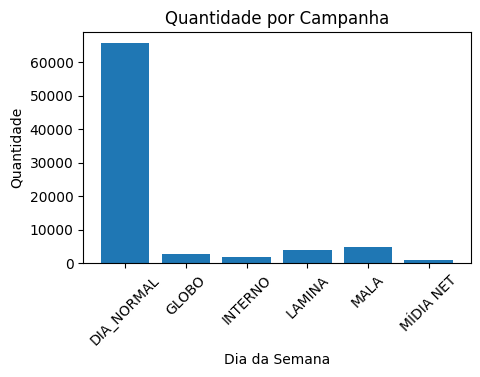

In [14]:
# plot sales x marketing campaign.

agrupado_emissora = df.groupby('EMISSORA')['QUANTIDADE'].sum().reset_index()

plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_emissora['EMISSORA'], agrupado_emissora['QUANTIDADE'])
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Campanha')
plt.xticks(rotation=45)

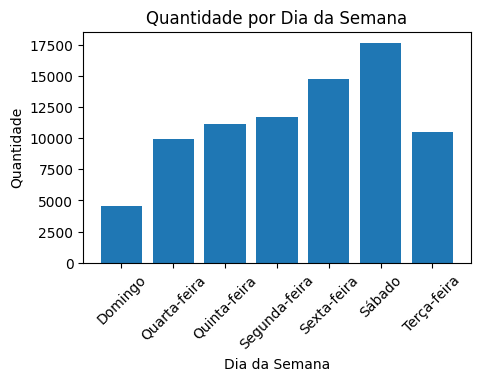

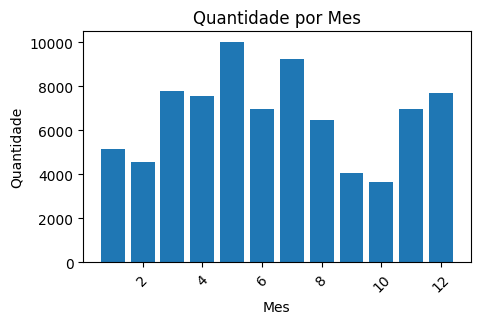

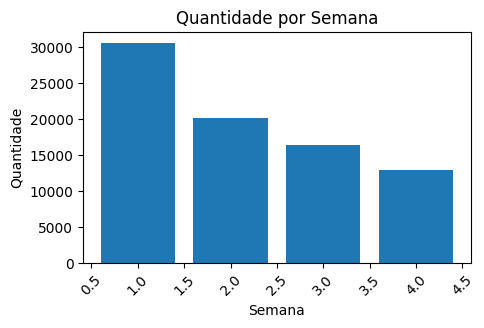

In [15]:
# plot sales x day of the week, week and month.

agrupado = df.groupby('DIA_SEMANA')['QUANTIDADE'].sum().reset_index()

plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado['DIA_SEMANA'], agrupado['QUANTIDADE'])
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Dia da Semana')
plt.xticks(rotation=45)

agrupado_mes = df.groupby('MES')['QUANTIDADE'].sum().reset_index()
plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_mes['MES'], agrupado_mes['QUANTIDADE'])
plt.xlabel('Mes')
plt.ylabel('Quantidade')
plt.title('Quantidade por Mes')
plt.xticks(rotation=45)

agrupado_semana = df.groupby('SEMANA')['QUANTIDADE'].sum().reset_index()
plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_semana['SEMANA'], agrupado_semana['QUANTIDADE'])
plt.xlabel('Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Semana')
plt.xticks(rotation=45)

plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19664 entries, 0 to 30017
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DESCRICAO   19664 non-null  object 
 1   QUANTIDADE  19664 non-null  float64
 2   PRECO       19664 non-null  float64
 3   EMISSORA    19664 non-null  object 
 4   DIA_SEMANA  19664 non-null  object 
 5   SEMANA      19664 non-null  int64  
 6   MES         19664 non-null  int64  
 7   ANO         19664 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [17]:
df.head()

,DESCRICAO,QUANTIDADE,PRECO,EMISSORA,DIA_SEMANA,SEMANA,MES,ANO
0,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,28.0,700.0,DIA_NORMAL,Segunda-feira,2,1,2022
4,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,5.0,557.0,DIA_NORMAL,Quarta-feira,1,1,2023
6,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,1.0,626.0,DIA_NORMAL,Terça-feira,3,1,2022
9,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,44.0,549.0,DIA_NORMAL,Quinta-feira,4,1,2022
11,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,1.0,602.0,DIA_NORMAL,Segunda-feira,4,1,2022


In [18]:
# get categorical dummies:

colunas_categoricas = ['SEMANA', 'MES', 'ANO', 'DIA_SEMANA', 'EMISSORA']

df_dummies = pd.DataFrame()

for col in colunas_categoricas:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    df_dummies = pd.concat([df_dummies, dummies], axis=1)

df = pd.concat([df, df_dummies], axis=1)

In [27]:
X = df.drop(['QUANTIDADE', 'DESCRICAO', 'DIA_SEMANA', 'SEMANA', 'MES', 'ANO', 'EMISSORA'], axis=1)
y = df['QUANTIDADE']

In [28]:
# test split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [29]:
# fit linear regression model.

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

In [52]:
# see results performance

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Erro Médio Quadrático (MSE): {mse}')
print(f'Coeficiente de Determinação (R²): {r2}')

Erro Médio Quadrático (MSE): 26.686827692245714
Coeficiente de Determinação (R²): 0.8509370453704187


In [ ]:
# Mean Squared Error. It is a measure of the average squared difference between the actual values and the predicted values in a regression model. Here, the MSE value is approximately 26.69.

# R-squared (R²), is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variables in a regression model. An R² value of approximately 0.851 indicates that about 85.1% of the variance in the dependent variable can be explained by the independent variables in the model.

In [53]:
# see all results back to excel:

df_resultados = pd.DataFrame({'Real': y_test, 'Previsao': y_pred})

df_resultados.to_excel('resultados_regressao.xlsx', index=False)